# Visualizing Correlations

i = 9, Image=data\n03594945_jeep.JPEG


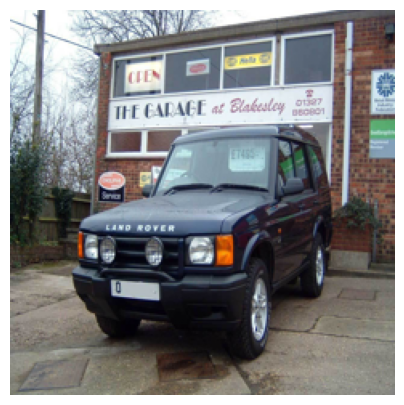

Number of concepts=11
Highly correlated concepts for image 9 with threshold 0.15: [(5, 2), (5, 7)]


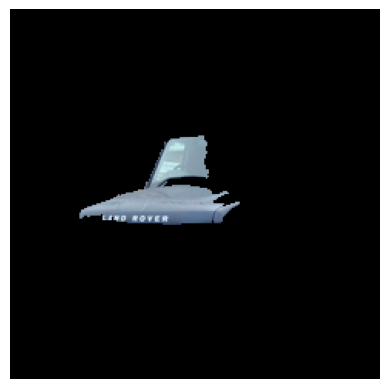

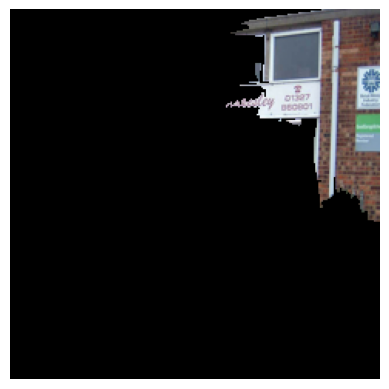

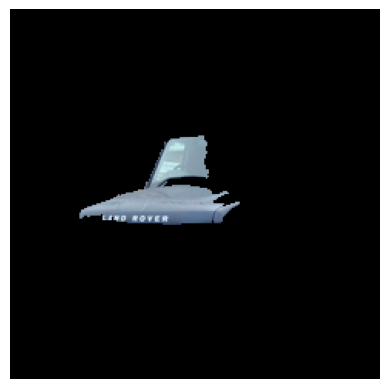

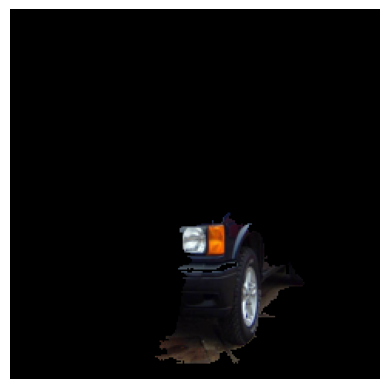

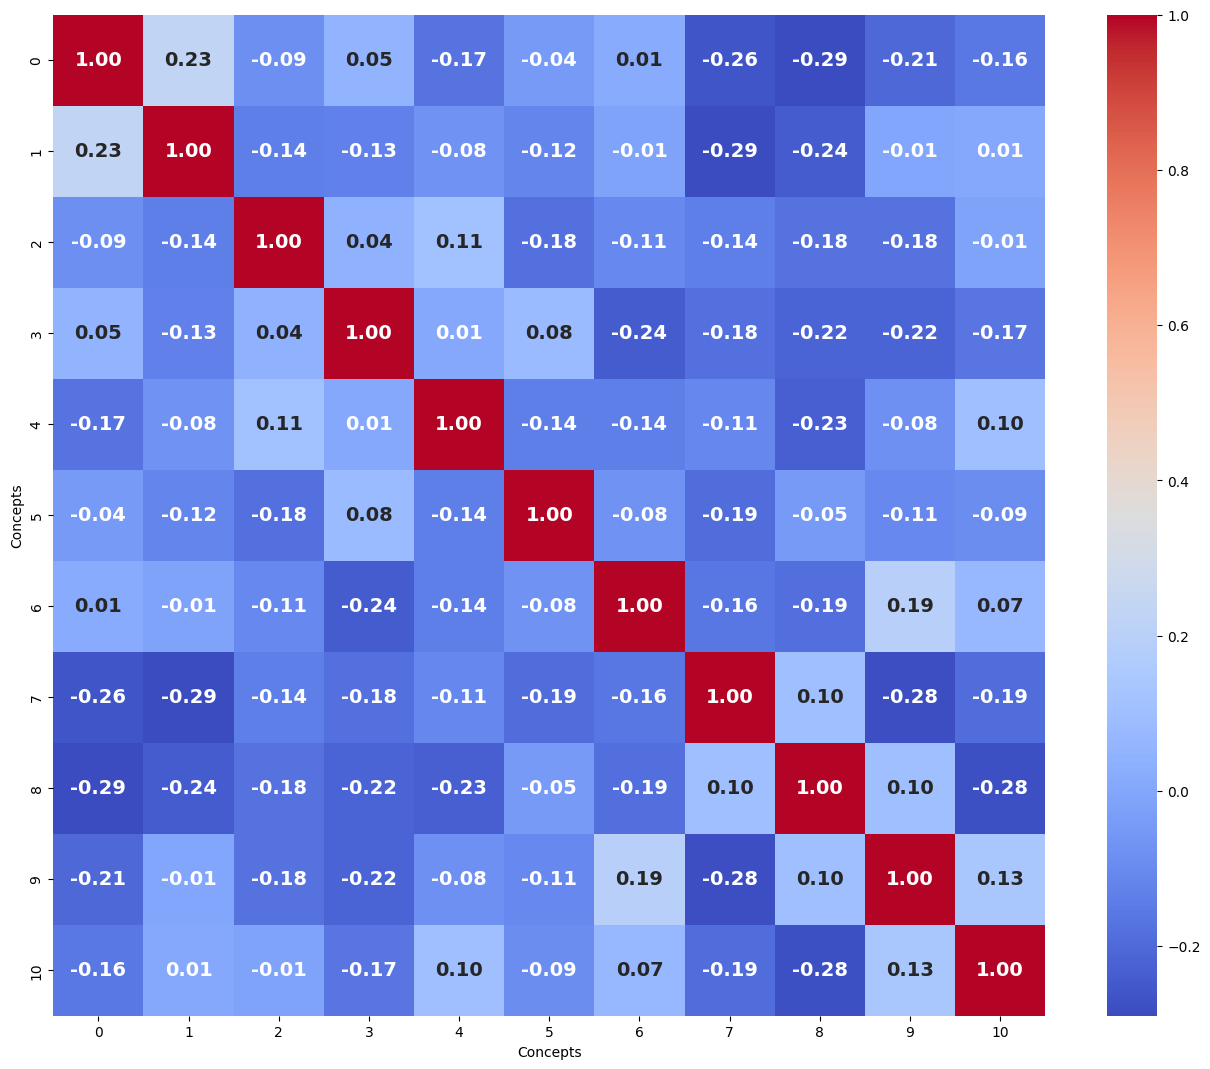

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import models
from sklearn.metrics.pairwise import cosine_similarity
from skimage.segmentation import slic

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def plot_concept(image, masks, index):
    """
    Plot a single concept from an image based on its segmentation mask.
    
    Args:
        image: Input image as numpy array
        masks: List of segmentation masks
        index: Index of the concept to plot
    """
    concept_image = image.copy()
    mask = masks[index]["segmentation"]
    concept_image[mask == 0] = 0

    plt.figure(figsize=(5, 5))
    plt.imshow(concept_image)
    plt.title(f"")
    plt.axis('off')
    plt.show()


def plot_all_concepts(image, masks, correlated_indices):
    """
    Plot all concepts and highlight highly correlated ones.
    
    Args:
        image: Input image as numpy array
        masks: List of segmentation masks
        correlated_indices: List of tuples containing indices of correlated concepts
    """
    num_concepts = len(masks)
    grid_size = int(np.ceil(np.sqrt(num_concepts)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    for i, ax in enumerate(axes.flat):
        if i < num_concepts:
            concept_image = image.copy()
            mask = masks[i]["segmentation"]
            concept_image[mask == 0] = 0
            ax.imshow(concept_image)
            ax.axis('off')
            
            # Highlight highly correlated concepts
            if any(i in pair for pair in correlated_indices):
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(2)
        else:
            ax.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


class ConceptVectorDataset(Dataset):
    """Dataset class for concept vectors."""
    
    def __init__(self, concept_vectors, labels):
        """
        Initialize the dataset.
        
        Args:
            concept_vectors: List of concept vectors
            labels: List of labels for each concept vector
        """
        self.concept_vectors = concept_vectors
        self.labels = labels

    def __len__(self):
        return len(self.concept_vectors)
    
    def __getitem__(self, idx):
        concept_vector = self.concept_vectors[idx]
        # Transpose dimensions to match expected input shape [channels, height, width]
        concept_vector = torch.tensor(concept_vector).permute(2, 0, 1).float()
        label = self.labels[idx]
        return concept_vector, label


def compute_gradients(model, criterion, data_loader):
    """
    Compute gradients of the model with respect to the input.
    
    Args:
        model: PyTorch model
        criterion: Loss function
        data_loader: DataLoader containing the input data
        
    Returns:
        2D array of flattened gradients
    """
    gradients_list = []
    model.eval()

    for input_data, label in data_loader:
        input_data, label = input_data.to(DEVICE), label.to(DEVICE)
        outputs = model(input_data)
        loss = criterion(outputs, label)

        model.zero_grad()

        gradient_tuple = torch.autograd.grad(
            outputs=loss,
            inputs=[
                param for _, param in model.named_parameters() if param.requires_grad
            ],
        )

        gradients_list.append(gradient_tuple)

    # Flatten and convert to NumPy arrays
    flattened_gradients = [
        np.concatenate([g.detach().cpu().numpy().flatten() for g in gradient_tuple])
        for gradient_tuple in gradients_list
    ]
    # Stack to form a 2D array
    gradients_2d_array = np.vstack(flattened_gradients)
    return gradients_2d_array


def extract_features(model, data_loader):
    """
    Extract feature maps from the last convolutional layer of the model.
    
    Args:
        model: PyTorch model
        data_loader: DataLoader containing the input data
        
    Returns:
        NumPy array of feature maps
    """
    model.eval()
    features_list = []

    def get_last_conv_layer(model):
        if isinstance(model, torch.nn.Sequential):
            return model[-1]
        for name, layer in reversed(list(model.named_modules())):
            if isinstance(layer, torch.nn.Conv2d):
                return layer
        raise ValueError("No convolutional layer found in the model")

    last_conv_layer = get_last_conv_layer(model)
    feature_maps = []

    def hook(module, input, output):
        feature_maps.append(output)

    hook_handle = last_conv_layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(DEVICE)
            model(inputs)
            features = feature_maps[-1]
            features_list.append(features.cpu().numpy())
            feature_maps.clear()

    hook_handle.remove()
    features_np = np.concatenate(features_list, axis=0)
    return features_np


def highly_correlated_indices(corr_matrix, threshold, concept_index):
    """
    Find indices of concepts that are highly correlated with the given concept.
    
    Args:
        corr_matrix: Correlation matrix of shape (num_concepts, num_concepts)
        threshold: Correlation threshold
        concept_index: Index of the concept to find correlations for
        
    Returns:
        List of tuples containing indices of highly correlated concepts
    """
    num_concepts = corr_matrix.shape[0]
    correlated_indices = []

    i = concept_index
    for j in range(num_concepts):
        if i == j:  # Skip the same concept
            continue
        if abs(corr_matrix[i, j]) > threshold:
            correlated_indices.append((i, j))

    return correlated_indices


def get_concept_vectors(image, masks, flatten=True):
    """
    Extract concept vectors from an image using segmentation masks.
    
    Args:
        image: Input image as numpy array
        masks: List of segmentation masks
        flatten: Whether to flatten the concept vectors
        
    Returns:
        NumPy array of concept vectors
    """
    concept_vectors = []
    for mask in masks:
        mask = mask["segmentation"]
        # Apply mask to each channel
        concept = image * mask[:, :, np.newaxis]
        if flatten:
            concept = concept.flatten()
        concept_vectors.append(concept)
    return np.array(concept_vectors)


def centralize_vectors(images_concept_vectors):
    """
    Centralize concept vectors for each image separately.
    
    Args:
        images_concept_vectors: List of concept vectors for each image
        
    Returns:
        List of centralized concept vectors
    """
    centralized_images_concept_vectors = []
    for concept_vectors in images_concept_vectors:
        mean_vector = np.mean(concept_vectors, axis=0)
        centralized = concept_vectors - mean_vector
        centralized_images_concept_vectors.append(centralized)

    return centralized_images_concept_vectors


def get_correlation_matrix(images_centralized_vectors):
    """
    Compute correlation matrix between concept vectors.
    
    Args:
        images_centralized_vectors: List of centralized concept vectors
        
    Returns:
        List of correlation matrices
    """
    images_correlation_matrices = []
    for centralized_vectors in images_centralized_vectors:
        correlation_matrix = cosine_similarity(centralized_vectors)
        images_correlation_matrices.append(correlation_matrix)
    return images_correlation_matrices


def main():
    # Configuration
    option = 2  # 1=Raw Image, 2=CNN Feature Map, 3=Network Gradients
    
    # Load the model
    model = models.resnet50(weights="IMAGENET1K_V2").to(DEVICE)
    model.eval()

    # Directories
    concepts_dir = "Concepts/data/SAM2"
    data_dir = "data"

    # Load ImageNet class mapping
    df_label_mapping = pd.read_csv("imagenet_classes.csv")
    class_mapping = dict(zip(df_label_mapping['class_code'], df_label_mapping['class_number']))

    concept_vectors = []
    
    # Process images
    for i, file in enumerate(os.listdir(data_dir)):
        if "jeep" not in file:
            continue

        image_path = os.path.join(data_dir, file)
        print(f"Processing image {i}: {image_path}")
        
        class_code = file.split('_')[0]
        label = class_mapping.get(class_code, None)

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        resize_image = image.resize((240, 240))
        image = np.array(resize_image) / 255  # Normalize to [0,1]

        # Display the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        # Generate superpixel segmentations
        segments_slic = slic(image, n_segments=20, compactness=20, sigma=0)
        masks = [{"segmentation": segments_slic == label} for label in np.unique(segments_slic)]
        print(f"Number of concepts: {len(masks)}")
        
        if option == 1:
            # Option 1: Raw image concept vectors
            concept_vectors.append(get_concept_vectors(image, masks, flatten=True))
        elif option == 2:
            # Option 2: CNN feature map concept vectors
            image_concept_vectors = get_concept_vectors(image, masks, flatten=False)
            concept_labels = [label] * len(masks)
            dataset = ConceptVectorDataset(image_concept_vectors, concept_labels)
            dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
            feature_maps = extract_features(model, dataloader)
            feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)
            concept_vectors.append(feature_maps)
        elif option == 3:
            # Option 3: Network gradients concept vectors
            image_concept_vectors = get_concept_vectors(image, masks, flatten=False)
            concept_labels = [label] * len(masks)
            dataset = ConceptVectorDataset(image_concept_vectors, concept_labels)
            dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
            G_concepts = compute_gradients(
                model, torch.nn.CrossEntropyLoss(reduction="mean"), dataloader
            )
            concept_vectors.append(G_concepts)
    
    # Centralize concept vectors
    centralized_image_concept_vectors = centralize_vectors(concept_vectors)
    
    # Compute correlation matrices
    image_correlation_matrices = get_correlation_matrix(centralized_image_concept_vectors)

    # Find highly correlated concepts
    threshold = 0.15
    concept_index = 5
    correlated_concepts_indices = highly_correlated_indices(
        image_correlation_matrices[0], threshold, concept_index=concept_index
    )
    print(f"Highly correlated concepts with threshold {threshold}: {correlated_concepts_indices}")

    # Plot highly correlated concepts
    for i, j in correlated_concepts_indices:
        plot_concept(image, masks, i)
        plot_concept(image, masks, j)

    # Plot correlation matrix heatmap
    plt.figure(figsize=(16, 13))
    sns.heatmap(
        image_correlation_matrices[0], 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        annot_kws={"size": 14, "weight": "bold"}
    )
    plt.xlabel('Concepts')
    plt.ylabel('Concepts')
    plt.show()


if __name__ == "__main__":
    main()

# Concept SHAP + Concept correlation

Seed: 0, Data: imagenet
Model: resnet50
explaining 10000 images
Experiment: Concept Correlation SHAP
Option: 3
AUC version: insertion
Iteration = 0


  0%|          | 0/10000 [00:00<?, ?it/s]

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000008.JPEG


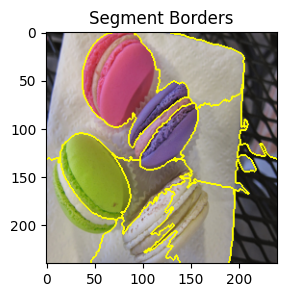

Number of concepts=12


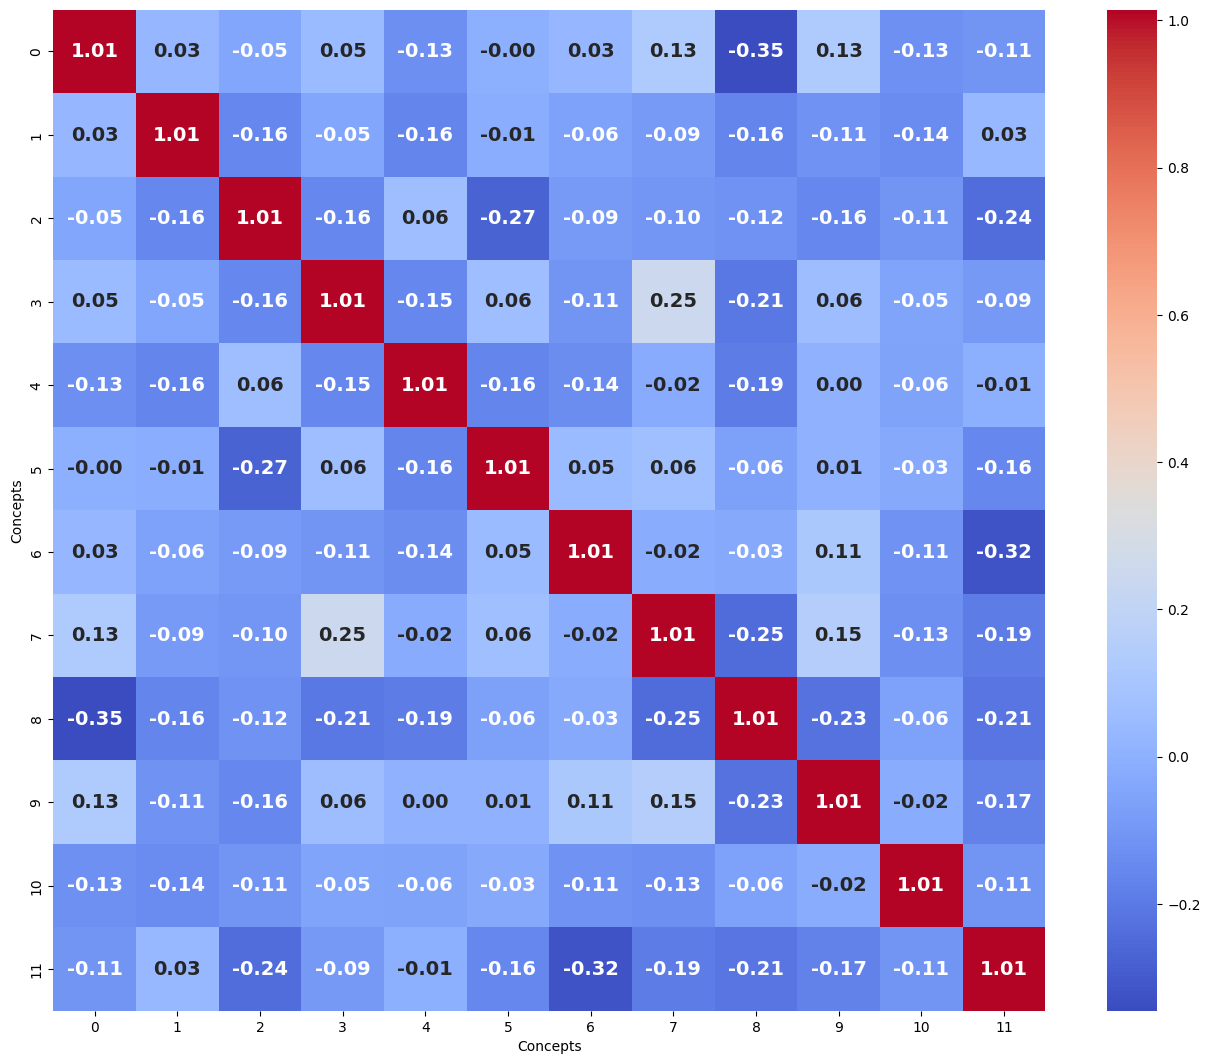

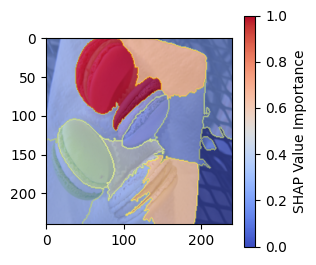

  0%|          | 1/10000 [00:03<8:49:04,  3.17s/it]

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000012.JPEG


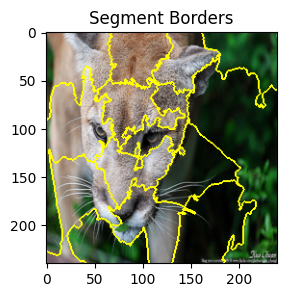

Number of concepts=14


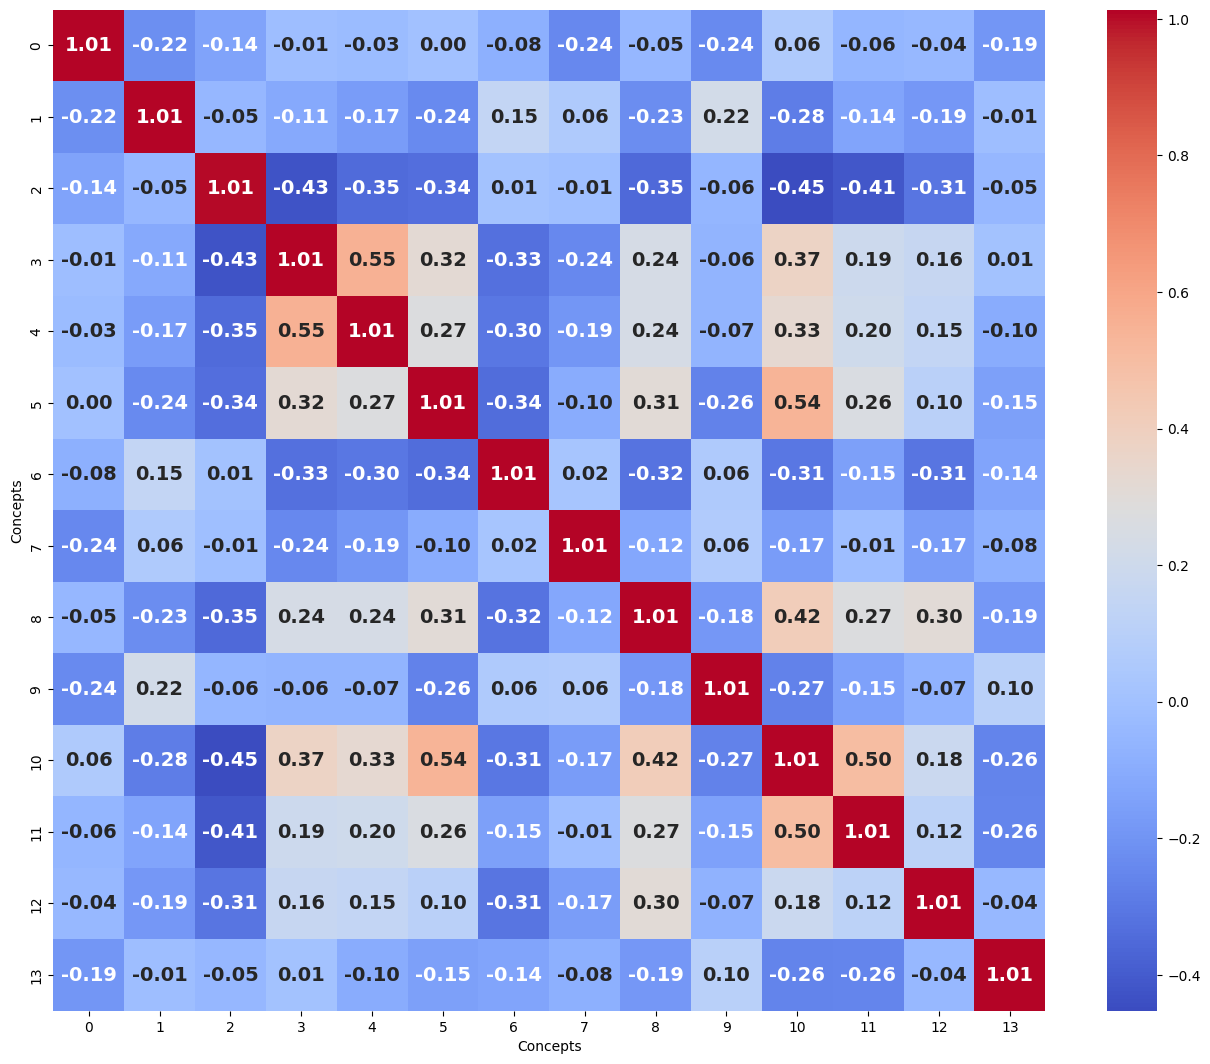

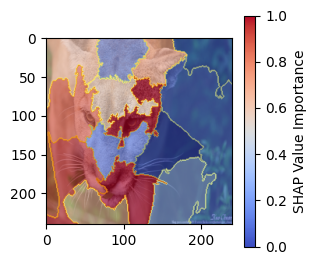

  0%|          | 2/10000 [00:06<9:33:03,  3.44s/it]

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000023.JPEG


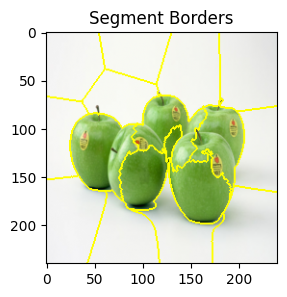

Number of concepts=16


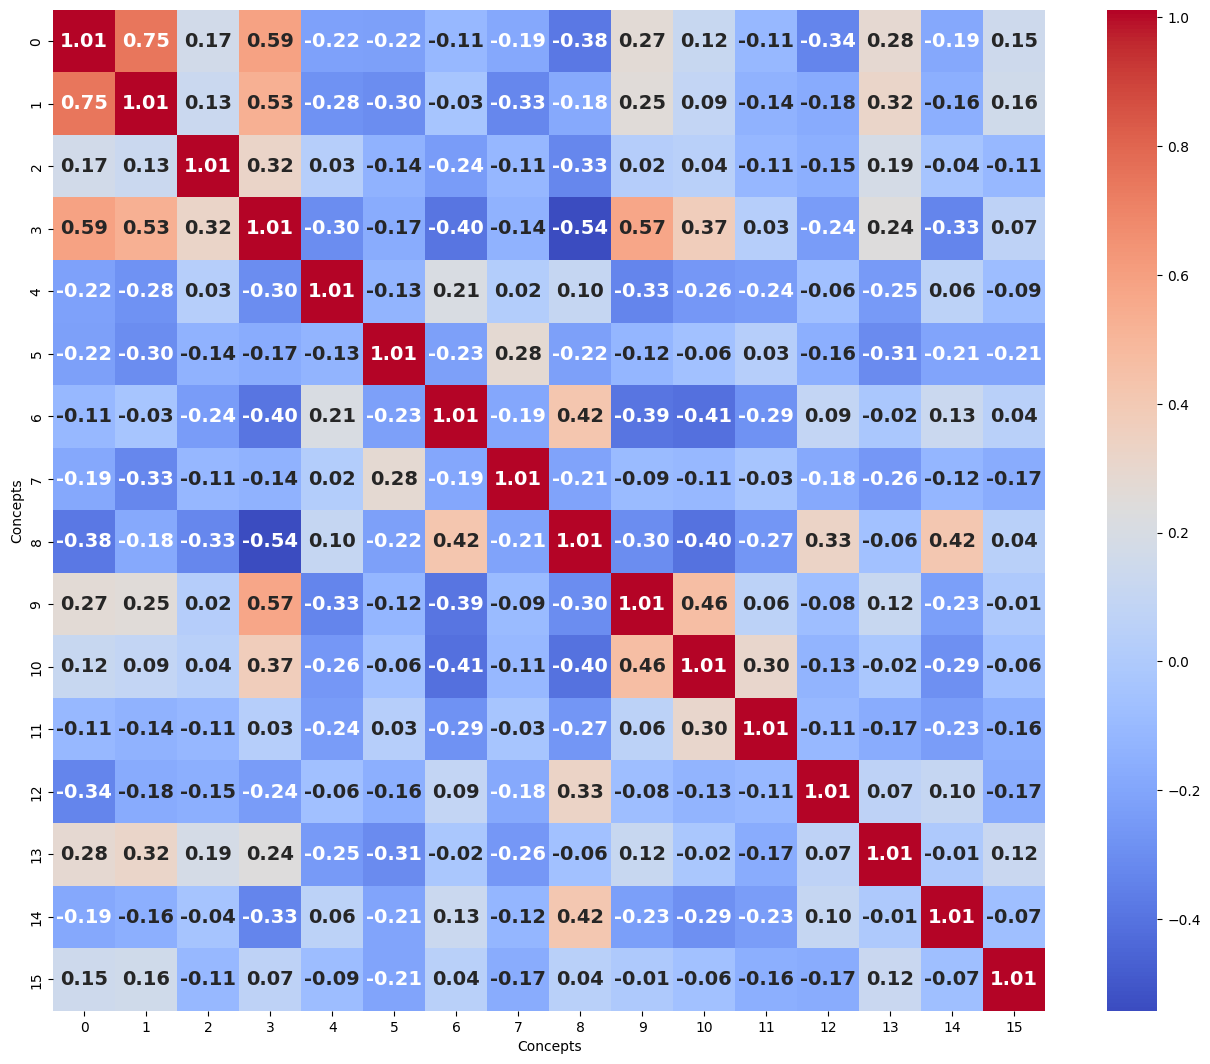

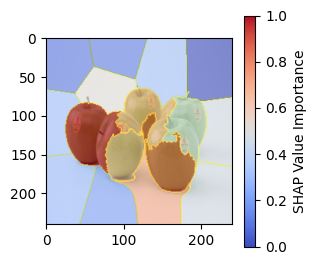

  0%|          | 3/10000 [00:10<10:17:50,  3.71s/it]

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000024.JPEG


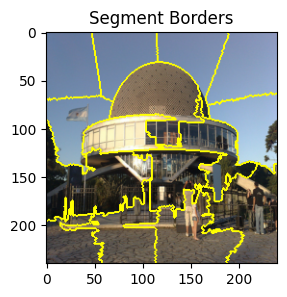

Number of concepts=15


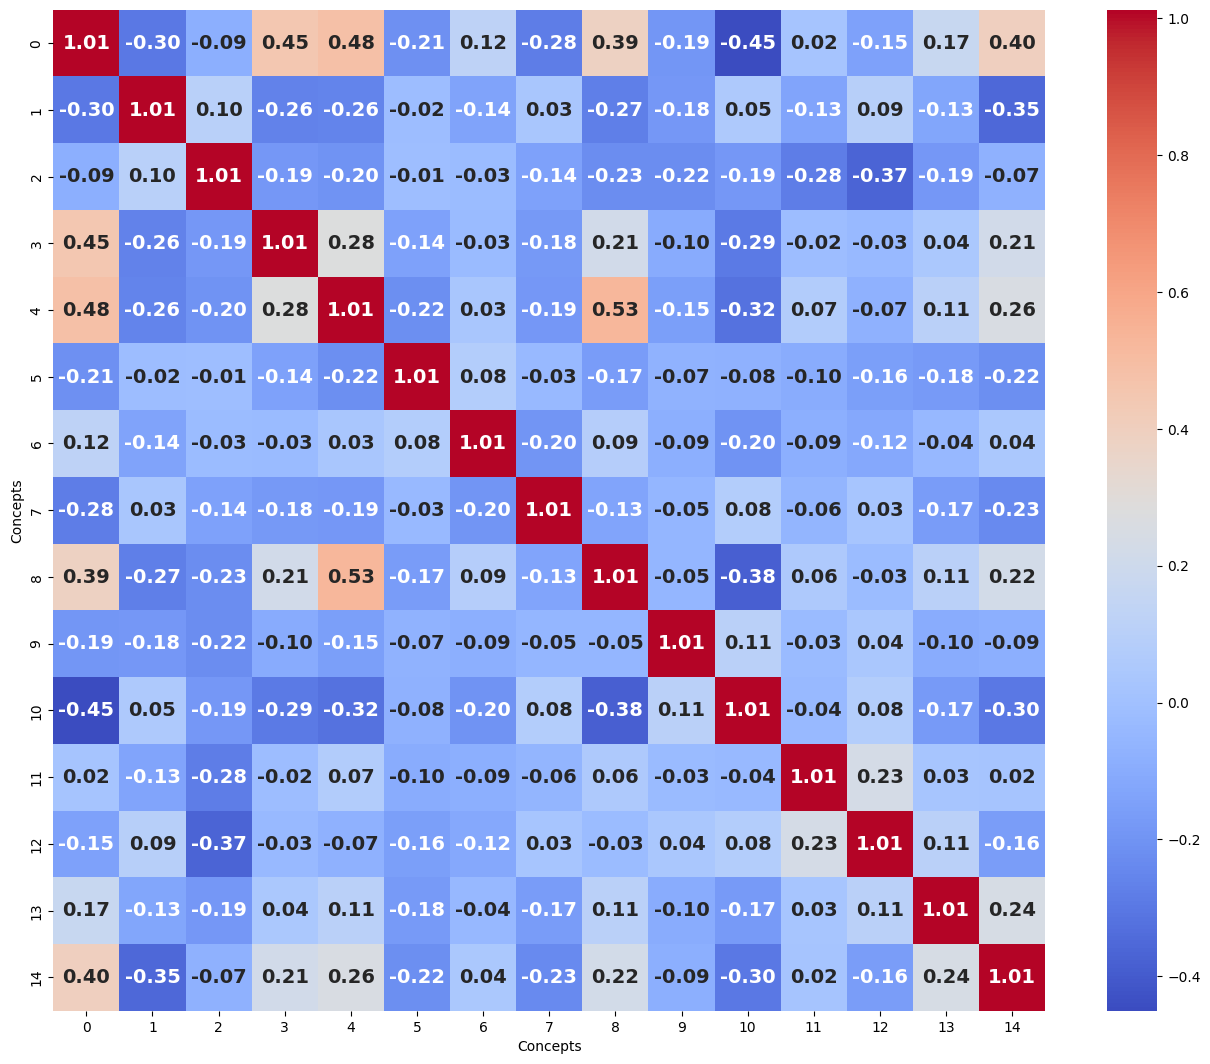

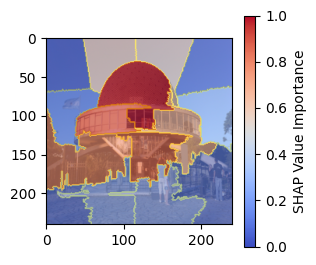

  0%|          | 4/10000 [00:14<10:17:02,  3.70s/it]

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000040.JPEG


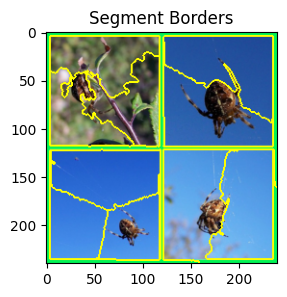

Number of concepts=11


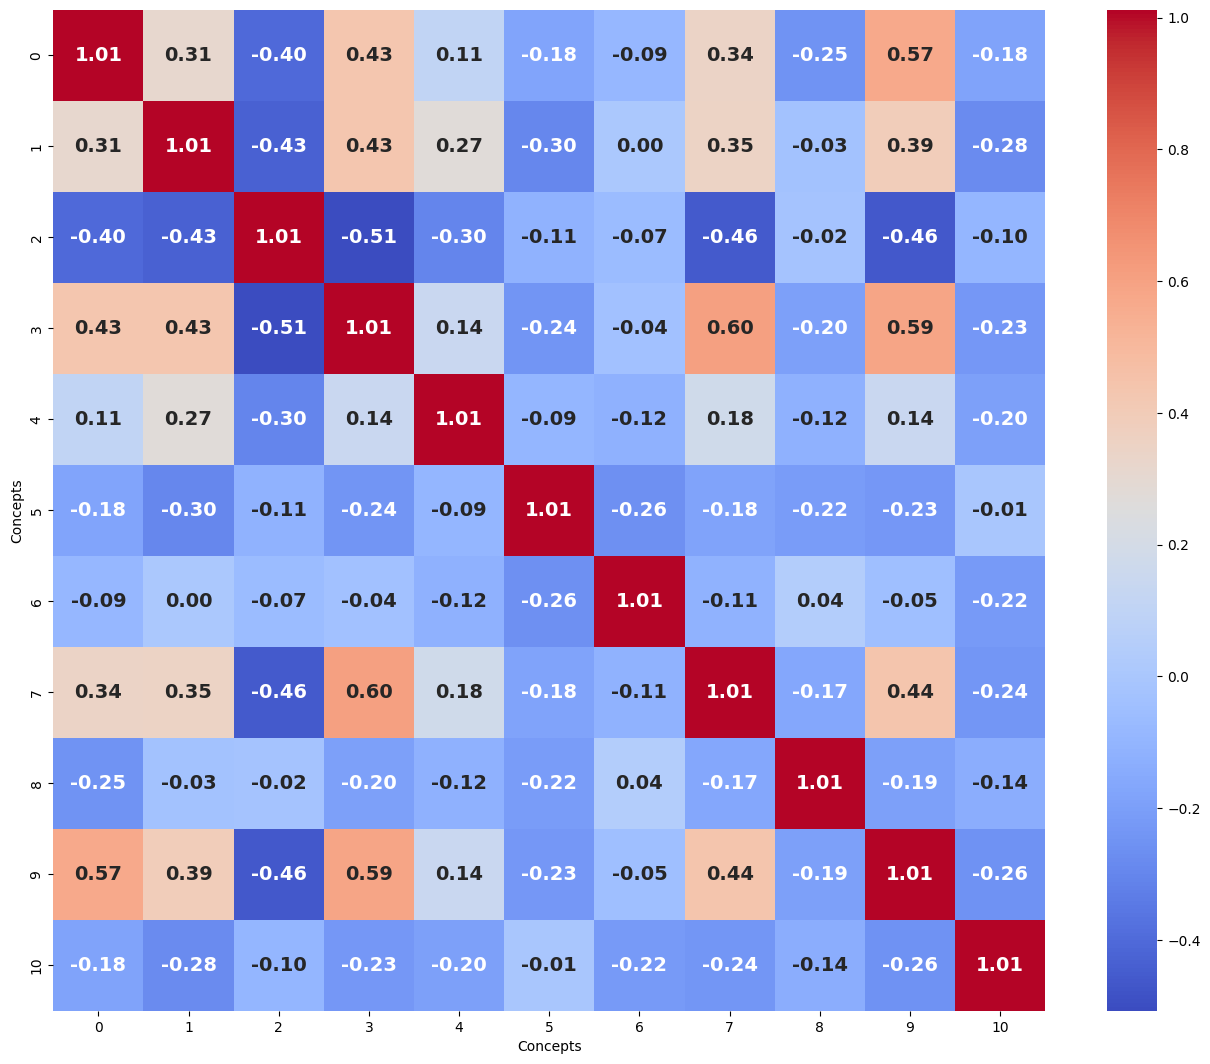

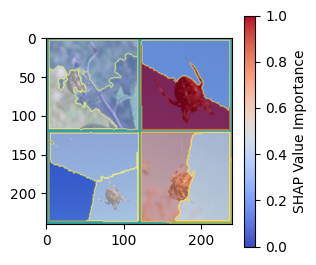

  0%|          | 5/10000 [00:17<9:30:16,  3.42s/it] 

Explaining image: ../../data/extracted_imagenet_images\ILSVRC2012_val_00000042.JPEG


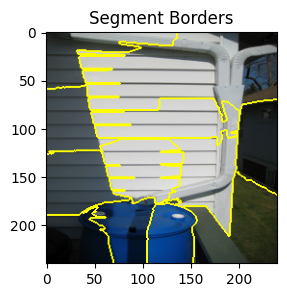

Number of concepts=12


  0%|          | 5/10000 [00:19<10:45:05,  3.87s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from PIL import Image
from torchvision import transforms, models
import torchvision
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
import os
import time
from sklearn import metrics
import pandas as pd
import itertools
import math
from sklearn.metrics.pairwise import cosine_similarity
from skimage.segmentation import quickshift, slic, felzenszwalb, mark_boundaries
from skimage import img_as_float
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------Concept correlation-------------------------
class ConceptVectorDataset(Dataset):
    def __init__(self, concept_vectors, labels):
        self.concept_vectors = concept_vectors
        self.labels = labels

    def __len__(self):
        return len(self.concept_vectors)
    
    def __getitem__(self, idx):
        concept_vector = self.concept_vectors[idx]
        # Transpose the dimensions to match the expected input shape [channels, height, width]
        concept_vector = torch.tensor(concept_vector).permute(2, 0, 1).float()
        label = self.labels[idx]
        return concept_vector, label
    

def compute_gradients(model, criterion, data_loader):
    gradients_list = []
    model.eval()

    for input, label in data_loader:
        input, label = input.to(device), label.to(device)
        outputs = model(input)
        loss = criterion(outputs, label)

        model.zero_grad()

        gradient_tuple = torch.autograd.grad(
            outputs=loss,
            inputs=[
                param for _, param in model.named_parameters() if param.requires_grad
            ],
        )

        gradients_list.append(gradient_tuple)

    # Flatten and convert to NumPy arrays
    flattened_gradients = [
        np.concatenate([g.detach().cpu().numpy().flatten() for g in gradient_tuple])
        for gradient_tuple in gradients_list
    ]
    # Stack to form a 2D array
    gradients_2d_array = np.vstack(flattened_gradients)
    return gradients_2d_array


# Get feature map from the last convolutional layer for images
def extract_features(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    features_list = []

    def get_last_conv_layer(model):
        if isinstance(model, torch.nn.Sequential):
            return model[-1]
        for name, layer in reversed(list(model.named_modules())):
            if isinstance(layer, torch.nn.Conv2d):
                return layer
        raise ValueError("No convolutional layer found in the model")

    last_conv_layer = get_last_conv_layer(model)
    feature_maps = []

    def hook(module, input, output):
        feature_maps.append(output)

    hook_handle = last_conv_layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            model(inputs)
            features = feature_maps[-1]
            features_list.append(features.cpu().numpy())
            feature_maps.clear()

    hook_handle.remove()
    features_np = np.concatenate(features_list, axis=0)
    return features_np


# function which accept correlation matrix of shape (num_concepts, num_concepts), concept_index and threshold, and returns indices of concepts that are highly correlated with that concept such that corr[i][j]>threshold and corr[i][j]<-threshold
def highly_correlated_indices(corr_matrix, threshold, concept_index):
    num_concepts = corr_matrix.shape[0]
    correlated_indices = []

    # for i in range(num_concepts):
    i = concept_index
    for j in range(0, num_concepts):  # Only check upper triangle to avoid duplicates
        if i == j: # skip the same concept
            continue
        if corr_matrix[i, j] > threshold or corr_matrix[i, j] < -threshold:
            correlated_indices.append((i, j))

    return correlated_indices
# Example usage:
# corr_matrix = np.array([[1.0, 0.8, -0.9], [0.8, 1.0, 0.4], [-0.9, 0.4, 1.0]])
# threshold = 0.7
# print(highly_correlated_indices(corr_matrix, threshold))

def get_concept_vectors(image, masks, flatten = True):
    image = image_norm(Image.fromarray(image)).numpy().transpose(1, 2, 0)
    concept_vectors = []
    for mask in masks:
        mask = mask["segmentation"] # shape (240,240)
        # Apply mask to each channel (240,240,3)
        concept = image * mask[:, :, np.newaxis]  # keeps only values where mask is True 
        # Flatten the concept into a 1D vector
        if  flatten:
            concept = concept.flatten()  
        concept_vectors.append(concept)
    return np.array(concept_vectors) # shape (num_concepts, 240*240*3)


def centralize_vectors(images_concept_vectors):
    # this function centralizes concepts for each image separately
    # concept_vectors is here list of lists for each image list of flattened concept vectors
    
    centralized_images_concept_vectors = []
    for concept_vectors in images_concept_vectors:
        # Find the mean vector
        mean_vector = np.mean(concept_vectors, axis=0)
        # Subtract the mean vector from each vector
        centralized = concept_vectors - mean_vector
        centralized_images_concept_vectors.append(centralized)

    return centralized_images_concept_vectors

# Option 1: cosine between normalized concept vectors
def get_correlation_matrix(images_centralized_vectors):
    images_correlation_matrices = []
    for centralized_vectors in images_centralized_vectors:
        correlation_matrix = cosine_similarity(centralized_vectors) # shape (num_concepts, num_concepts) eg (20, 20) where i,j element is cosine similarity between i-th and j-th centralized concept vector
        images_correlation_matrices.append(correlation_matrix)
    return images_correlation_matrices

# Function that returns the correlation matrix between concepts for an image
def get_concept_correlation(model, image, label, masks, option):
    concept_vectors = [] # shape (1, num_concepts, *)
    if option == 1:
        # Option 1: raw image concept vectors
        # concept_vectors is here list of lists for each image list of flattened concept vectors
        concept_vectors.append(get_concept_vectors(image, masks, flatten = True))
    elif option == 2:
        # Option 2: last CNN feature map concept vectors
        image_concept_vectors = get_concept_vectors(image, masks, flatten = False) # (num_concepts, 240, 240,3)
        concept_labels = [label] * len(masks) # each concept has same label as the image
        dataset = ConceptVectorDataset(image_concept_vectors, concept_labels)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        feature_maps = extract_features(model, dataloader)
        # flatten each feature map
        feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)
        concept_vectors.append(feature_maps)
    elif option == 3: # this takes a lot of time to execute because gradients are huge vectors
        # Option 3: network gradients (normalized NTK) concept vectors
        image_concept_vectors = get_concept_vectors(image, masks, flatten = False) # (num_concepts, 240, 240,3)
        concept_labels = [label] * len(masks) # each concept has same label as the image
        dataset = ConceptVectorDataset(image_concept_vectors, concept_labels)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        G_concepts = compute_gradients(
            model, torch.nn.CrossEntropyLoss(reduction="mean"), dataloader
        ) 
        concept_vectors.append(G_concepts)  
    
    centralized_image_concept_vectors = centralize_vectors(concept_vectors) # only one image passed to function => size (1, num_concepts, *)

    # correlation between all concepts for each image, shape (num_images, num_concepts, num_concepts)
    image_correlation_matrices = get_correlation_matrix(centralized_image_concept_vectors)

    if len(image_correlation_matrices) != 1:
        raise ValueError("Expected only one image, but got more than one")

    # there should be only one image in the list
    return image_correlation_matrices[0]

# -------------------------------------------------------------
# -----------------Baseline - Monte Carlo SHAP-----------------
def monte_carlo_shap(model, image, concepts, num_samples=100):
    """
    Compute the SHAP values for an image using a PyTorch model with Monte Carlo approximation.

    Args:
        model: The model to evaluate.
        image (np.ndarray): The input image as a NumPy array (H, W, C).
        concepts (list): A list of mask dictionaries, each containing a "segmentation" key.
        num_samples (int): The number of samples to use for the Monte Carlo approximation.

    Returns:
        np.ndarray: The SHAP values for each concept in the input image.
    """
    numpy_image = image.copy()
    normalized_image = image_norm(Image.fromarray(numpy_image)).numpy().transpose(1, 2, 0)

    # extract image dimensions
    h, w, _ = image.shape
    n = len(concepts)  # |N|

    output, probabilities = transform_and_predict(model, [image], norm=True)
    shap_values = np.zeros((n, output.shape[1])) # (num_concepts, num_classes) = (20, 1000)

    with torch.no_grad():
        for k in range(n):  # index of concept to calculate SHAP importance
            for _ in range(num_samples):
                # Randomly sample a subset of features
                subset = random.sample(range(n), random.randint(0, n-1))
                if k in subset:
                    subset.remove(k)

                s = len(subset)  # |S|

                # S - subsets of N without k
                combined_mask = np.zeros((h, w), dtype=bool)
                for idx in subset:
                    combined_mask = np.logical_or(combined_mask, concepts[idx]["segmentation"])

                # Combined mask U {k}
                combined_mask_union_k = np.logical_or(combined_mask, concepts[k]["segmentation"])

                # Apply mask to the image
                combined_mask_image = normalized_image.copy()
                combined_mask_image[~combined_mask] = 0
                combined_mask_union_k_image = normalized_image.copy()
                combined_mask_union_k_image[~combined_mask_union_k] = 0

                # Compute the model outputs
                combined_mask_image = torch.tensor(combined_mask_image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
                combined_mask_union_k_image = torch.tensor(combined_mask_union_k_image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)

                p_S = model(combined_mask_image).detach().cpu().numpy()
                p_S_union_k = model(combined_mask_union_k_image).detach().cpu().numpy()

                # Compute SHAP contribution
                contribution = (p_S_union_k - p_S).squeeze()

                weight: float = (math.factorial(s) * math.factorial(n - s - 1)) / math.factorial(n)
                shap_values[k] += weight * contribution

    return shap_values

# -------------------------------------------------------------

def visualize_auc_masks(image, auc_masks):
    for i, auc_mask in enumerate(auc_masks):
        # Multiply the image with auc_mask
        visualized_image = image * auc_mask[:, :, np.newaxis]
        # Display the result
        plt.figure()
        plt.imshow(visualized_image.astype(np.uint8))
        plt.title(f'AUC Mask {i+1}')
        plt.axis('off')
        plt.show()

def visualize_images(imgs_numpy):
    for i, img in enumerate(imgs_numpy):
        plt.imshow(img)
        plt.title(f'Image {i+1}')
        plt.axis('off')
        plt.show()


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def plot_heatmap_correlation(correlation_matrix):
    # plot heatmap for correlation matrix
    plt.figure(figsize=(16, 13))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'')
    # plt.title(f'Correlation Heatmap for Image {image_index}')
    plt.xlabel('Concepts')
    plt.ylabel('Concepts')
    plt.show()


# Generate all combinations of elements in indices_list - indices of mutually correlated concepts, removing current concept
def generate_index_combinations_for_list(indices_list_pairs, remove_k):
    indices_list = list(set([idx for pair in indices_list_pairs for idx in pair]))  # get unique indices
    if remove_k in indices_list: # if k is in the list, remove it
        indices_list.remove(remove_k)
    combinations = [[]]  # Start with the empty set
    for r in range(1, len(indices_list) + 1):
        combinations.extend(itertools.combinations(indices_list, r))
    return [list(comb) for comb in combinations]

def transform_and_predict(model, images, norm=True):
    if norm:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    batch = []
    for img in images:
        batch.append(transform(Image.fromarray(img)).unsqueeze(0))
    inputs = torch.cat(batch).to(device)
    outputs = model(inputs)
    return outputs.detach().cpu().numpy(), outputs.softmax(dim=1).detach().cpu().numpy()

# Full SHAP explanations using concept correlation
def get_shap_concept_importance(model, image, concepts, threshold, option):
    """
    Compute the SHAP values for an image using a PyTorch model.

    Args:
        model: The model to evaluate.
        image (np.ndarray): The input image as a NumPy array (H, W, C).
        concepts (list): A list of mask dictionaries, each containing a "segmentation" key.

    Returns:
        np.ndarray: The SHAP values for each concept in the input image.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    numpy_image = image.copy()
    normalized_image = image_norm(Image.fromarray(numpy_image)).numpy().transpose(1, 2, 0)

    # extract image dimensions
    h, w, _ = image.shape

    n = len(concepts)  # |N|

    # image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
    # output = model(image)
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)

    output, probabilities = transform_and_predict(model, [image], norm=True)
    label = np.argmax(probabilities)

    shap_values = np.zeros(
        (n, output.shape[1])
    )  # Initialize shap_values with the correct shape

    # get concepts correlation
    concept_correlation_matrix = get_concept_correlation(model, numpy_image, label, masks, option)

    plot_heatmap_correlation(concept_correlation_matrix)

    with torch.no_grad():
        for k in range(n):  # index of concept to calculate SHAP importance
            # index_combinations = generate_index_combinations_without_k(n, k)

            # get correlated concepts indices
            correlated_concepts_indices = highly_correlated_indices(concept_correlation_matrix, threshold=threshold, concept_index=k)

            # Find list of indices of correlated concepts and then generate combinations only for those indices
            index_combinations = generate_index_combinations_for_list(correlated_concepts_indices, remove_k=k)
            for (
                combination
            ) in index_combinations:  # e.g. n=3, k=0 =>  [[], [1], [2], [1, 2]]
                s = len(combination)  # |S|

                # S - subsets of N without k
                combined_mask = np.zeros((h, w), dtype=bool)
                # if [] comined_mask is all zeros => baseline (black image)
                for idx in combination:
                    combined_mask = np.logical_or(
                        combined_mask, concepts[idx]["segmentation"]
                    )

                # Combined mask U {k}
                combined_mask_union_k = np.logical_or(
                    combined_mask, concepts[k]["segmentation"]
                )

                # Apply mask to the image
                image = normalized_image
                combined_mask_image = image.copy()
                combined_mask_image[~combined_mask] = 0
                combined_mask_union_k_image = image.copy()
                combined_mask_union_k_image[~combined_mask_union_k] = 0

                # using logits instead of probabilities to ensure that the attributions are consistent and additive. 
                combined_mask_image = torch.tensor(combined_mask_image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
                combined_mask_union_k_image = torch.tensor(combined_mask_union_k_image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)

                p_S = model(combined_mask_image).detach().cpu().numpy()
                p_S_union_k = model(combined_mask_union_k_image).detach().cpu().numpy()

                # Compute SHAP contribution
                contribution = (p_S_union_k - p_S).squeeze()

                weight = (
                    math.factorial(s) * math.factorial(n - s - 1)
                ) / math.factorial(n)
                shap_values[k] += weight * contribution

    return shap_values


def load_concepts(concepts_dir, image_name):
    image_concepts_dir = os.path.join(concepts_dir, image_name)
    masks = []
    for mask_file in os.listdir(image_concepts_dir):
        mask_path = os.path.join(image_concepts_dir, mask_file)
        with np.load(mask_path) as data:
            mask = {"segmentation": data["segmentation"]}
            masks.append(mask)
    return masks


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.image_files = [
            os.path.join(images_folder, f)
            for f in os.listdir(images_folder)
            if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".JPEG")
        ]
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename = self.image_files[index]
        # Load image
        image = Image.open(filename).convert("RGB")
        image = resize_image(image)
        # if self.transform is not None:
        #     image = self.transform(image)
        image = np.array(image)
        return image, filename


test_preprocess = transforms.Compose(
    [
        # transforms.Resize(224),
        transforms.Resize(240),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image_norm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)  ### imagenet std and mean
# resize_image = transforms.Compose([transforms.Resize((224, 224))])
resize_image = transforms.Compose([transforms.Resize((240, 240))])

def get_auc_mask(model, image, masks, shap_values):

    # device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    preprocess_image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    preprocessed_image = preprocess_image(image).to(device)

    predict_org = torch.nn.functional.softmax(
        model(preprocessed_image.unsqueeze(0)), dim=1
    )
    target_class = int(torch.argmax(predict_org))
    target_prob = float(torch.max(predict_org))

    # Sort masks based on SHAP values
    sorted_indices = np.argsort(shap_values)[::-1]
    concept_masks = np.array([mask["segmentation"].tolist() for mask in masks])

    auc_masks = np.expand_dims(
        np.array(
            [
                concept_masks[sorted_indices[: i + 1]].sum(0)
                for i in range(len(sorted_indices))
            ]
        ).astype(bool),
        3,
    )

    return target_prob, target_class, auc_masks


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 0
    dataset_name = "imagenet"
    # dataset_name = "data"
    num_iterations = 1
    print(f"Seed: {seed}, Data: {dataset_name}")

    fix_seed(seed)

    if dataset_name == "imagenet":
        root_dir = "extracted_imagenet_images"
        concepts_dir = "./ImageNetRandom/SAM2"
    elif dataset_name == "data":
        concepts_dir = "Concepts/data"
        root_dir = "data"

    if not os.path.exists("results"):
        os.makedirs("results")

    for model_name in ["resnet50" , "mobilenet_v2", "vit_b16", "resnet18"]:
    # for model_name in ["resnet50"]:
        print(f"Model: {model_name}")

        # Load target model to explain
        if model_name == "resnet50":
            model = models.resnet50(weights="IMAGENET1K_V2").to(device)
        elif model_name == "mobilenet_v2":
            model = models.mobilenet_v2(weights="IMAGENET1K_V2").to(device)
        elif model_name == "vit_b16":
            model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
            resize_image = transforms.Compose([transforms.Resize((224, 224))]) # resize image to 224x224 for vit_b16
        elif model_name == "resnet18":
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
            resize_image = transforms.Compose([transforms.Resize((240, 240))]) 
        model = model.eval()

        img_net = MyDataset(images_folder=root_dir, transform=resize_image)
        num_sample = len(img_net)
        print("explaining {} images".format(num_sample))  # num_sample = 10000

        for experiment in ["Concept Correlation SHAP"]: 
            print(f"Experiment: {experiment}")
            threshold = None

            if experiment == "Concept Correlation SHAP":
                options = [3]
            elif experiment == "Monte Carlo SHAP":
                options = [None]
            
            for option in options:
                print(f"Option: {option}")

                for mask_type in [
                    # "MaskRCNN", 
                    "SLIC" 
                    # #"SAM2",
                ]:
                    for auc_version in ["insertion", "deletion"]:
                        auc_total = 0
                        auc_values = []
                        iteration_times = []

                        print(f"AUC version: {auc_version}")

                        for iteration in range(num_iterations):
                            print(f"Iteration = {iteration}")
                            
                            for idx in tqdm(range(num_sample)):
                                image, file_name = img_net[idx]
                                print(f"Explaining image: {file_name}")

                                # do only for 1000 images
                                if idx >=10:
                                    break

                                # img_name is after last "/"
                                # img_name = file_name.split("/")[-1]
                                img_name = file_name.split("\\")[-1]
                            
                                # Load concepts
                                if mask_type == "SAM2":
                                    # masks = masks_sam2
                                    masks = load_concepts(concepts_dir + "/SAM2", img_name)
                                elif mask_type == "Quickshift":
                                    image_float = img_as_float(image)
                                    # kernel_size - Width of Gaussian kernel used in smoothing the sample. Larger values result in larger segments, max_dist - Maximum distance between pixels to be linked in a segment. Larger values result in larger segments. ratio - Balances color-space proximity and image-space proximity. Higher values give more weight to color-space proximity.
                                    segments_quickshift = quickshift(image_float, kernel_size=4, max_dist=200, ratio=0.2)
                                    masks = [{"segmentation": segments_quickshift == label} for label in np.unique(segments_quickshift)]
                                elif mask_type == "SLIC":
                                    # n_segments - The (approximate) number of labels in the segmented output image, compactness - Balances color proximity and space proximity. Higher values make the algorithm give more weight to space proximity, resulting in more compact superpixels, sigma - Width of Gaussian smoothing kernel applied to the image before segmentation.
                                    segments_slic = slic(image, n_segments=20, compactness=20, sigma=0)
                                    masks = [{"segmentation": segments_slic == label} for label in np.unique(segments_slic)]
                                elif mask_type == "Fenzelswalb":
                                    # scale - Balances the importance of color-space proximity and image-space proximity. Larger values result in larger segments, sigma - Width of Gaussian smoothing kernel applied to the image before segmentation, min_size - Minimum component size. Enforces a minimum size for the segments.
                                    segments_felzenszwalb = felzenszwalb(image, scale=500, sigma=2, min_size=300)
                                    masks = [{"segmentation": segments_felzenszwalb == label} for label in np.unique(segments_felzenszwalb)]
                                # elif mask_type == "MaskRCNN":
                                #     seg_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
                                #     seg_model.eval()
                                #     seg_model.to(device)
                                #     torch_image = image_norm(image).unsqueeze(0)
                                #     seg_prediction = seg_model(torch_image.to(device))
                                #     masks = []
                                #     for i in range(len(seg_prediction[0]["masks"])):
                                #         mask = seg_prediction[0]["masks"][i].detach().cpu().numpy()
                                #         mask = (mask>0.5).astype(np.uint8).squeeze() # Threshold the mask to get a binary mask
                                #         masks.append({"segmentation": mask})

                                # TODO Added these two functions to show segments and color segments based on importance for first image in the paper - Run this
                                # -------showing segments--------
                                def show_segment_borders(image, masks):
                                    segments_slic = np.zeros_like(image[..., 0])
                                    for i, mask in enumerate(masks):
                                        segments_slic[mask["segmentation"]] = i + 1
                                    
                                    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
                                    ax.imshow(mark_boundaries(image, segments_slic))
                                    ax.set_title('Segment Borders')
                                    plt.show()

                                show_segment_borders(image, masks)
                                # --------------------------------

                                
                                print(f"Number of concepts={len(masks)}")

                                start_time = time.time()
                                if experiment == "Monte Carlo SHAP":
                                    shap_values = monte_carlo_shap(model, image, masks, num_samples=100)
                                elif experiment == "Concept Correlation SHAP":
                                    threshold = 0.5
                                    shap_values = get_shap_concept_importance(model, image, masks, threshold, option) # shape (num_concepts, num_classes) = (*, 1000) for imagenet

                                # find the most important concept index where shap_value[index][predicted_class] is the highest
                                _, probabilities = transform_and_predict(model, [image], norm=True)
                                predicted_class = np.argmax(probabilities)
                                # predicted_class = torch.argmax(torch.nn.functional.softmax(model(image_norm(image).unsqueeze(0).to(device)), dim=1)).item()
                                shap_values_for_class = np.array([shap_value[predicted_class] for shap_value in shap_values])

                                # ---------Color Segments based on importance-------
                                def color_segments_by_importance(image, masks, shap_values):
                                    from matplotlib.colors import Normalize
                                    from matplotlib.cm import ScalarMappable
                                    segments_slic = np.zeros_like(image[..., 0])
                                    for i, mask in enumerate(masks):
                                        segments_slic[mask["segmentation"]] = i + 1

                                    # Normalize SHAP values to [0, 1] for coloring
                                    norm_shap_values = (shap_values - np.min(shap_values)) / (np.max(shap_values) - np.min(shap_values))
                                    
                                    # Create an empty image to store the heatmap
                                    heatmap = np.zeros_like(image[..., 0], dtype=np.float32)
                                    
                                    for i, mask in enumerate(masks):
                                        heatmap[mask["segmentation"]] = norm_shap_values[i]
                                    
                                    # Apply a colormap to the heatmap
                                    cmap = plt.get_cmap("coolwarm")
                                    norm = Normalize(vmin=0, vmax=1)
                                    heatmap_colored = cmap(norm(heatmap))
                                    
                                    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
                                    ax.imshow(mark_boundaries(image, segments_slic))
                                    ax.imshow(heatmap_colored, alpha=0.6)  # Overlay the heatmap with some transparency
                                    ax.set_title('')
                                    
                                    # Add colorbar
                                    sm = ScalarMappable(cmap=cmap, norm=norm)
                                    sm.set_array([])
                                    cbar = plt.colorbar(sm, ax=ax)
                                    cbar.set_label('SHAP Value Importance')
                                    
                                    plt.show()


                                color_segments_by_importance(image, masks, shap_values_for_class)
                                # ----------------------------------------------
